# Imports

In [1]:
import requests
import json
import folium
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, cut_tree
import matplotlib.pyplot as plt
import pandas as pd
import overpy
import os
import alphashape
import shapely
from matplotlib.patches import Polygon

# 1. Fetch Data

## 1.1.Data preprocessing

Using [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) to query locations that fulfill the given conditions. In this case, all [amenities](https://wiki.openstreetmap.org/wiki/Key:amenity), but all bus stations could be selected

In [2]:
api = overpy.Overpass()

location = "Granada"
road_distance = "2000"  # (m)

query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.where;
node(area.where)[highway=bus_stop];
out body;
>;
out skel qt;'''


# Selectin ALL amenities
query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.granada;
(
  node(area.granada)[amenity](37.120, -3.650, 37.300, -3.570);
);
out body;
>;
out skel qt;
'''

response = api.query(query)

In [81]:
# Preparing the dataframe [id,latitude,longitude]
df = pd.DataFrame(
    columns=["id","lat","lon"])

for node in response.get_nodes():
    # Adding all the position information of nodes
    new_row = pd.DataFrame(
        {"id": node.id,
         "lat": node.lat,
         "lon": node.lon},
         index=[0])

    df = pd.concat([df,new_row],axis=0)

# Formatted information into a DataFrame, only for convenience
df.reset_index(inplace=True, drop=True)
print(df)

               id         lat         lon
0        83533572  37.1868974  -3.6036270
1        88144037  37.1946846  -3.6228425
2       267489671  37.1868624  -3.5919396
3       290912866  37.2016761  -3.6155480
4       290969327  37.1741866  -3.5852181
...           ...         ...         ...
5275  12613072802  37.1736029  -3.5982325
5276  12613073001  37.1733682  -3.5975351
5277  12618982989  37.1780865  -3.6092263
5278  12624010583  37.1683284  -3.5973407
5279  12624036228  37.1653565  -3.5990484

[5280 rows x 3 columns]


Number of detected possible places: 5280


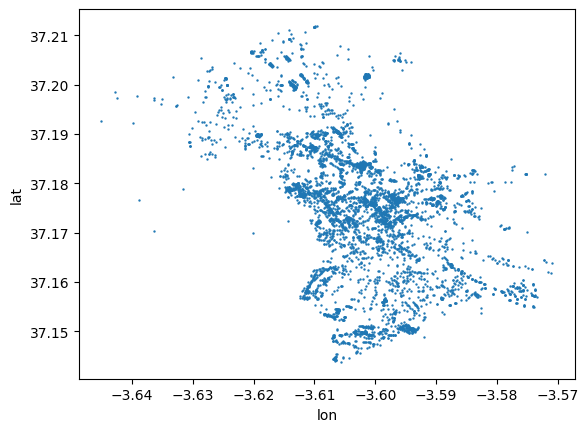

In [50]:
plt.scatter(x=df["lon"],y=df["lat"], s=0.5)
plt.xlabel("lon")
plt.ylabel("lat")
print("Number of detected possible places:", len(df.index))

## 1.2.Algorithm

Preprocessing: We will be using a clustering algorithm to hierarchically organize the bus stations. So the QUBO can be implemented layer by layer in the same hierarchical approach. This way, we exploit the fractal network that bus stops are

## 1.1.Data preprocessing

In [178]:
class linkageCut:
    def __init__(self, df):
        self.scaler = MinMaxScaler()
        self.data = X = self.scaler.fit_transform(df[['lon','lat']].values)
        self.linkage_matrix = linkage(self.data, method='ward')
        self.tree_cut = cut_tree(self.linkage_matrix)
        
    def give_tree_cut(self):
        return self.tree_cut
    
    def __nunique(self, a, axis):
        ''' Count the number of unique elements in an array and axis'''
        return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

    def recursive_down(self, n_clusters, level, total_levels, mask):
        if len(str(level)) < total_levels:
            
            # Selecting specific parent cluster
            small_tree = self.tree_cut[mask]
            
            # Checking how many subclusters there are in the parent cluster for each step in
            # the clustering (ward) process
            small_tree_nclusters = self.__nunique(small_tree, axis=0)
            
            try:
                # This is the step where there are exactly n_clusters subclusters
                sub_tree_step = np.where(small_tree_nclusters == n_clusters)[0][-1]
            except:
                raise Exception("Some cluster cannot be further divided")
            # Now we truly have the subdivision
            
            counter = 1
            for sub_lbl in np.unique(small_tree[:,sub_tree_step]):
                # Now we prepare the mask for each subcluster and the recursion
                sub_data_mask = np.where(self.tree_cut[:, sub_tree_step] == sub_lbl)[0]
                write = self.recursive_down( 
                                   n_clusters, int(str(level) + str(counter)), total_levels,
                                   sub_data_mask)
                if write == None:
                    write = str(level) + str(counter)
                self.top_down[sub_data_mask, len(str(level))] = int(write)
                counter+=1
                
            return None
        else:
            return level
        
    def top_down_view_recur(self, n_clusters, levels=1):
        ''' Constructs a top down view in which each cluster is
        subsequently divided in 'n_clusters'. This process 
        is iterated 'level' times.
        In each step, all data is labelled accordingly.
        
        The naming conventions for the labels is 1,2, ..., n_clusters for 
        the first level, 11 for the first subcluster of cluster 1 and so on. Example:
        
        132 has 3 levels, in the order 1(top)-3(middle)-2(lowest)
        
        Obviously, the maximum n_clusters is 9 for our proof of concept, for larger values, 
        char implementations should be considered
        
        :input n_clusters: number of clusters per level
        :input levels: number of layers or levels
        :return: (len_data)X(level) matrix with labels
        '''
        self.n_clusters = n_clusters
        # First level
        if levels < 1:
            raise Exception("levels must be greater or equal to 1") 
        
        # The first level is, by definition, in the tree_cut indx
        # len_data - n_clusters 
        self.top_down = np.zeros((len(self.data), levels))
                          
        tree_step = len(self.tree_cut) - n_clusters
        first_lbls = np.unique(self.tree_cut[:, tree_step])
        
        # Second level
        for lbl in first_lbls:
            data_mask = np.where(self.tree_cut[:, tree_step] == lbl)[0]
            self.top_down[data_mask, 0] = lbl + 1
            self.recursive_down(n_clusters, lbl + 1, levels, data_mask)
            
        return self.top_down
    def give_centers(self, level):
        print(type(self.top_down))
        if type(self.top_down) != np.ndarray:
            print("You must first execute top_down_view_recur first")
        else:
            if level > self.top_down.shape[1]:
                print('Level out of bounds')
            else:      
                sub_top_down = self.top_down[:,level]
                level_labels = np.unique(sub_top_down)
                centers = np.zeros((len(level_labels),2))
                for i in range(len(level_labels)):
                    cluster_mask = sub_top_down == level_labels[i]
                    centers[i] = np.mean(self.scaler.inverse_transform(self.data[cluster_mask]), axis=0)
            return centers
        

n_cluster = 6    
levels = 2
linkage_matrix = linkageCut(df)
top_down = linkage_matrix.top_down_view_recur(clusters, levels)


Text(0.5, 1.0, 'Kmeans for comparison')

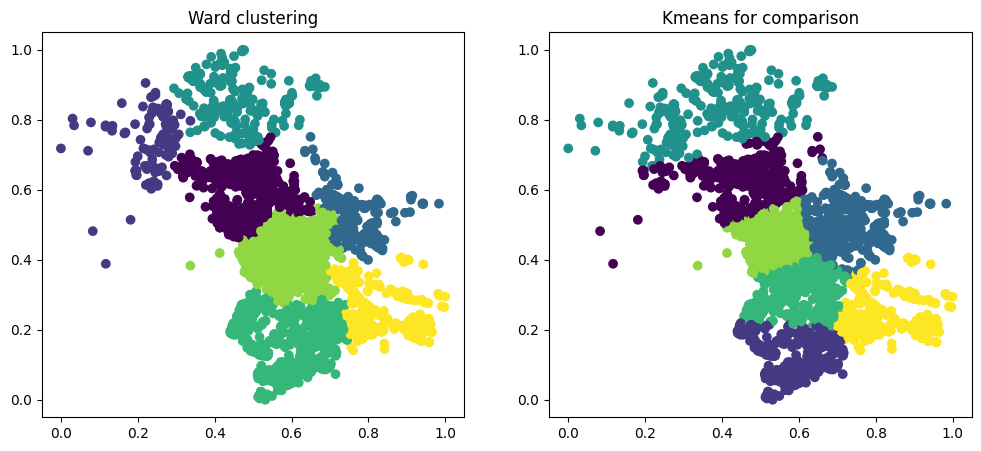

In [179]:
data_size = len(df.index)
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['lon','lat']].values)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12,5))
agg_labels = top_down[:,0]
ax[0].scatter(X.T[0], X.T[1], c=agg_labels)
ax[0].set_title('Ward clustering')

clustering = KMeans(n_clusters)
labels = clustering.fit_predict(X)

ax[1].scatter(X.T[0], X.T[1], c=labels)
ax[1].set_title('Kmeans for comparison')

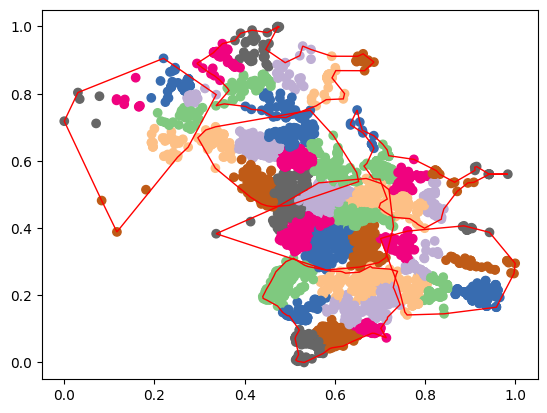

In [180]:
# fancy scatter
fig, ax = plt.subplots()
x = X[:, 0]
y = X[:, 1]
z = top_down[:,1]
plt.scatter(X[:,0], X[:,1], c=top_down[:,1]%10, cmap='Accent')
alpha_list = np.ones(n_clusters)
alpha_list[2:]*= 30
alpha_list[5:] = 1
for i in range(1,n_clusters+1):
    cluster = X[top_down[:,0] == i]
    alpha = alpha_list[i-1]
    hull = alphashape.alphashape(cluster, alpha)
    if type(hull)== shapely.geometry.multipolygon.MultiPolygon:
        areas = [ geom.area for geom in hull.geoms]
        # Select the component with larger area
        big = np.argmax(areas)
        hull_pts = hull.geoms[big].exterior.coords.xy
    else:
        hull_pts = hull.exterior.coords.xy
    poly_patch = Polygon(np.array(hull_pts).T, facecolor='none', edgecolor='red')
    ax.add_patch(poly_patch)

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
labels [ 1.  2.  3.  4.  5.  6.  7. 11. 12. 13. 14. 15. 16. 17. 21. 22. 23. 24.
 25. 26. 27. 31. 32. 33. 34. 35. 36. 37. 41. 42. 43. 44. 45. 46. 47. 51.
 52. 53. 54. 55. 56. 57. 61. 62. 63. 64. 65. 66. 67. 71. 72. 73. 74. 75.
 76. 77.]


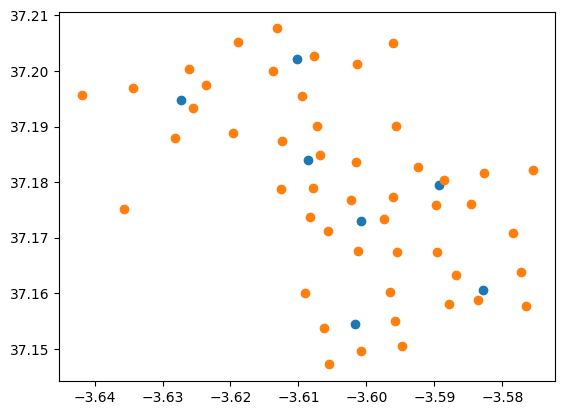

In [181]:
centers =  linkage_matrix.give_centers(0)
plt.scatter(*centers.T)
centers =  linkage_matrix.give_centers(1)
plt.scatter(*centers.T)
print("labels", np.unique(top_down))

In [182]:
def sample_data(df, labels, n_sampled_stops, seed = 140421):
  np.random.seed(seed)
  # We extract n samples from each cluster
  unique_labels = np.unique(labels)
  # first position is reserved for nonassigned data
  n_cluster = np.zeros(len(unique_labels))
  indices = np.indices(labels.shape)[0]
  cluster_indices = []
  max_cluster_size = int(n_sampled_stops/len(unique_labels))

  sample_indx = []

  for i in range(len(unique_labels)):
    filter_labels = labels == unique_labels[i]
    cluster_indices = indices[filter_labels]
    n_cluster[i] = len(cluster_indices)

    # Now we sample max_cluster_size
    extract_size = np.amin([max_cluster_size, n_cluster[i]]).astype(int)
    sample_indx.extend(np.random.choice(cluster_indices, size=extract_size, replace=False))
  final_data = pd.DataFrame(df.to_numpy()[sample_indx], columns=['id', 'lat', 'lon', 'index'])
  return final_data

# Since calculating driving distances is a costly process, we sample the data to obtain 
# something manageable
labels = top_down[:,0]
df['index'] = range(1, len(df) + 1)
n_sampled_stops = 100
final_data = sample_data(df, labels, n_sampled_stops)
print(final_data)

             id         lat         lon index
0    9786022817  37.1852606  -3.6047226  2992
1    6257690490  37.1779723  -3.6091317  1522
2    5810941447  37.1828105  -3.6019722   974
3    9673893920  37.1834345  -3.6023575  2872
4    9853127397  37.1793766  -3.6128016  2999
..          ...         ...         ...   ...
93  11933277290  37.1573693  -3.5786966  4820
94   9550277509  37.1665411  -3.5897244  2683
95   9585645197  37.1581967  -3.5851486  2790
96  11160284862  37.1556491  -3.5868738  4438
97  12533825415  37.1621265  -3.5858205  5126

[98 rows x 4 columns]


## 1.3.Map and driving distances

In [176]:
def map_show(data : pd.DataFrame, loc_coords):

  # Create a map centered on loc_coords [latitude, longitude]
  map = folium.Map(location=loc_coords, zoom_start=8)

  # Loop through the data and add markers for each location
  for i, row in data.iterrows():
      folium.Marker([row['lat'], row['lon']],
                    popup=row['id']).add_to(map)
  return map

means = final_data.mean()
means_lat_lon = [means[1], means[2]]
map_show(final_data, means_lat_lon)

/tmp/ipykernel_5320/1434851466.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means_lat_lon = [means[1], means[2]]


Now that fewer points are left, it is feasible to check the driving distances with the [OSRM API](http://project-osrm.org/docs/v5.5.1/api/) demo server.

Sending a query with the selected gas stations coordinates to OSRM API, an API desigend to calculate fastest driving distances (by car).

In [135]:
url = "http://router.project-osrm.org/table/v1/driving/"
routes = ""

# Query with longitude1,latitude1;longitude2,latitude2;...
for ind in final_data.index:
    routes += str(final_data["lon"][ind])+","+str(final_data["lat"][ind])+";"

routes = routes[:-1]

routes_response = requests.get(url+routes+"?annotations=distance")

In [136]:
dist_table_json = routes_response.json()
try:
    dist_table=np.array(dist_table_json["distances"])/1000 # meters to km
except:
    print("Too many bus stops, please reduce the n_sampled_stops")


np.savetxt(os.path.join("data", 'matriz-rutas-granada'), dist_table)
print(dist_table)


FileNotFoundError: [Errno 2] No such file or directory: 'data/matriz-rutas-granada'

## Closest pair from hierarchical cluster

Given a list of active edges, we must be able to fetch the start and end point of subsequent clusters of the hierarchical family. For that, we must fetch the next clusters and calculate the pairwise distance between nodes from multiple clusters.

[ 2  3  4  5  6  7  8  9 10 11 12 13 16 18 21 40 58 73 80 87]
[15 19 22 23 24 25 26 27 75]
(20, 9)
(np.int64(12), np.int64(6))


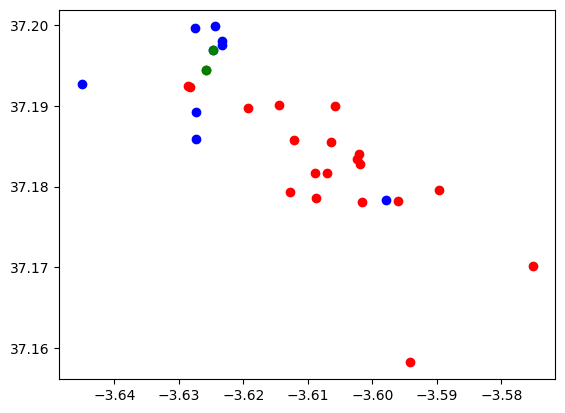

NameError: name 'min_distance_indx' is not defined

In [185]:
# WIP
def min_cluster_dist_ij(data, dist_table, i,j):
    sampled_top = top_down[data["index"].to_numpy().astype(np.uint), :]
    cluster_i = (sampled_top[:, 0] == i).nonzero()[0]
    cluster_j = (sampled_top[:, 0] == j).nonzero()[0]
    print(cluster_i)
    print(cluster_j)
    cluster_ij = dist_table[cluster_i,][:, cluster_j]
    # cluster_ji = dist_table[cluster_j][:, cluster_i]
    print(cluster_ij.shape)
    min_distance_index = np.unravel_index(np.argmin(cluster_ij), cluster_ij.shape)
    print(min_distance_index)
    pairs = cluster_ij[min_distance_index[0]], cluster_ij[min_distance_index[1]]
    plt.scatter(data.loc[cluster_i, "lon"], data.loc[cluster_i, "lat"], color="red")
    plt.scatter(data.loc[cluster_j, "lon"], data.loc[cluster_j, "lat"], color="blue")
    plt.scatter(data.loc[cluster_i[min_distance_index[0]], "lon"], data.loc[cluster_i[min_distance_index[0]], "lat"], color="green")
    plt.scatter(data.loc[cluster_j[min_distance_index[1]], "lon"], data.loc[cluster_j[min_distance_index[1]], "lat"], color="green")
    plt.show()
    return min_distance_indx
min_cluster_dist_ij(final_data, dist_table, 1,2)

# 2. Solve with QUBOSolver

In [13]:
#HERE EXECUTE QUBOSOLVER

## 2.1 Visualize QUBOSolver

In [14]:
def draw_line(df, line, color, map=None):
    means = df.mean()
    loc_coords = [means.iloc[1], means.iloc[2]]
    if map == None:
        map = folium.Map(location=loc_coords, zoom_start=8)
    # Get all connected positions from line adj matrix
    nonzero = np.nonzero(line)
    for i in range(len(nonzero[0])):
        indx1 = nonzero[0][i]
        indx2 = nonzero[1][i]

        pos_1 = df.iloc[indx1][['lat','lon']].values
        pos_2 = df.iloc[indx2][['lat','lon']].values
        folium.Marker(pos_1).add_to(map)
        folium.Marker(pos_2).add_to(map)
        colorline = folium.features.PolyLine([pos_1,pos_2], color=color)
        colorline.add_to(map)
    return map
line = np.genfromtxt(os.path.join("results", 'Line0.dat'))
map = draw_line(final_data, line, 'red')
line = np.genfromtxt(os.path.join("results", 'Line1.dat'))
map = draw_line(final_data, line, 'blue', map)
line = np.genfromtxt(os.path.join("results", 'Line2.dat'))
map = draw_line(final_data, line, 'green', map)
map